# 模型训练、评估与推理

在准备好数据集和模型后，就可以将数据送入模型中启动训练评估了，概括地讲包括如下几步：
1. **模型训练**：训练包括多轮迭代（epoch），每轮迭代遍历一次训练数据集，并且每次从中获取一小批（mini-batch）样本，送入模型执行前向计算得到预测值，并计算预测值（predict_label）与真实值（true_label）之间的损失函数值（loss）。执行梯度反向传播，并根据设置的优化算法（optimizer）更新模型的参数。观察每轮迭代的 loss 值减小趋势，可判断模型训练效果。
2. **模型评估**：将测试数据集送入训练好的模型进行评估，得到预测值，计算预测值与真实值之间的损失函数值（loss），并计算评价指标值（metric），便于评估模型效果。
3. **模型推理**：将待验证的数据（样本）送入训练好的模型执行推理，观察并验证推理结果（标签）是否符合预期。


飞桨框架提供了两种训练、评估与推理的方法：

- **使用飞桨高层 API**：先用 [paddle.Model](../../api/paddle/Model_cn.html) 对模型进行封装，然后通过 [Model.fit](../../api/paddle/Model_cn.html#fit-train-data-none-eval-data-none-batch-size-1-epochs-1-eval-freq-1-log-freq-10-save-dir-none-save-freq-1-verbose-2-drop-last-false-shuffle-true-num-workers-0-callbacks-none-accumulate-grad-batches-1-num-iters-none) 、 [Model.evaluate](../../api/paddle/Model_cn.html#evaluate-eval-data-batch-size-1-log-freq-10-verbose-2-num-workers-0-callbacks-none-num-iters-none) 、 [Model.predict](../../api/paddle/Model_cn.html#predict-test-data-batch-size-1-num-workers-0-stack-outputs-false-verbose-1-callbacks-none) 等完成模型的训练、评估与推理。该方式代码量少，适合快速上手。

- **使用飞桨基础 API**：提供了损失函数、优化器、评价指标、更新参数、反向传播等基础组件的实现，可以更灵活地应用到模型训练、评估与推理任务中，当然也可以很方便地自定义一些组件用于相关任务中。


高层 API 如 `Model.fit` 、 `Model.evaluate` 、 `Model.predict` 等都可以通过基础 API 实现，本文先介绍高层 API 的使用方式，然后将高层 API 拆解为基础 API 介绍，方便对比学习。


## 一、训练前准备

开始之前，需要使用下面的命令安装 Python 的 matplotlib 库，用于可视化图片。

In [ ]:
# 使用 pip 工具安装 matplotlib
! python3 -m pip install matplotlib -i https://mirror.baidu.com/pypi/simple

### 1.1 （可选）指定训练的硬件

模型训练时，需要用到 CPU、 GPU 等计算处理器资源，由于飞桨框架的安装包是区分处理器类型的，默认情况下飞桨框架会根据所安装的版本自动选择对应硬件，比如安装的 GPU 版本的飞桨，则自动使用 GPU 训练模型，无需手动指定。因此一般情况下，无需执行此步骤。

但是如果安装的 GPU 版本的飞桨框架，想切换到 CPU 上训练，则可通过 [paddle.device.set_device](../../api/paddle/device/set_device_cn.html#set-device) 修改。如果本机有多个 GPU 卡，也可以通过该 API 选择指定的卡进行训练，不指定的情况下则默认使用 'gpu:0'。

In [1]:
import paddle

# 指定在 CPU 上训练
paddle.device.set_device("cpu")

# 指定在 GPU 第 0 号卡上训练
# paddle.device.set_device('gpu:0')

Place(cpu)

需要注意的是，使用 `paddle.device.set_device` 时，只能使用 `CUDA_VISIBLE_DEVICES` 设置范围内的显卡，例如可以设置`export CUDA_VISIBLE_DEVICES=0,1,2` 和 `paddle.device.set_device('gpu:0')`，但是设置 `export CUDA_VISIBLE_DEVICES=1` 和 `paddle.device.set_device('gpu:0')` 时会冲突报错。


> 注：
> * 本文仅以单机单卡场景为例，介绍模型训练的方法，如果需要使用单机多卡、多机多卡训练，请参考如下章节：[分布式训练](../06_distributed_training/index_cn.html)。
> * 飞桨框架除了支持在 CPU、GPU 上训练，还支持在百度昆仑芯 XPU、华为昇腾 NPU 等 AI 计算处理器上训练，对应的训练指导请参考 [硬件支持](../hardware_support/index_cn.html) 章节。


### 1.2 准备训练用的数据集和模型

模型训练前，需要先完成数据集的加载和模型组网，以 MNIST 手写数字识别任务为例，代码示例如下：


In [6]:
from paddle.vision.transforms import Normalize

transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")
# 加载 MNIST 训练集和测试集
train_dataset = paddle.vision.datasets.MNIST(mode="train", transform=transform)
test_dataset = paddle.vision.datasets.MNIST(mode="test", transform=transform)

# 模型组网，构建并初始化一个模型 mnist
mnist = paddle.nn.Sequential(
    paddle.nn.Flatten(1, -1),
    paddle.nn.Linear(784, 512),
    paddle.nn.ReLU(),
    paddle.nn.Dropout(0.2),
    paddle.nn.Linear(512, 10),
)



## 二、使用 paddle.Model 高层 API 训练、评估与推理


以手写数字识别任务为例，使用高层 API 进行模型训练、评估与推理的步骤如下：


### 2.1 使用 paddle.Model 封装模型

使用高层 API 训练模型前，可使用 [paddle.Model](../../api/paddle/Model_cn.html) 将模型封装为一个实例，方便后续进行训练、评估与推理。代码如下：

In [4]:
# 封装模型为一个 model 实例，便于进行后续的训练、评估和推理
model = paddle.Model(mnist)

### 2.2 使用 Model.prepare 配置训练准备参数

用 `paddle.Model` 完成模型的封装后，需通过 [Model.prepare](../../api/paddle/Model_cn.html#prepare-optimizer-none-loss-none-metrics-none-amp-configs-none) 进行训练前的配置准备工作，包括设置优化算法、Loss 计算方法、评价指标计算方法：

- **优化器（optimizer）**：即寻找最优解的方法，可计算和更新梯度，并根据梯度更新模型参数。飞桨框架在 [paddle.optimizer](../../api/paddle/optimizer/Overview_cn.html#paddle-optimizer) 下提供了优化器相关 API。并且需要为优化器设置合适的学习率，或者指定合适的学习率策略，飞桨框架在 [paddle.optimizer.lr](../../api/paddle/optimizer/Overview_cn.html#about-lr) 下提供了学习率策略相关的 API。
- **损失函数（loss）**：用于评估模型的预测值和真实值的差距，模型训练过程即取得尽可能小的 loss 的过程。飞桨框架在 [paddle.nn Loss层](../../api/paddle/nn/Overview_cn.html#loss) 提供了适用不同深度学习任务的损失函数相关 API。
- **评价指标（metrics）**：用于评估模型的好坏，不同的任务通常有不同的评价指标。飞桨框架在 [paddle.metric](../../api/paddle/metric/Overview_cn.html) 下提供了评价指标相关 API。


In [5]:
# 为模型训练做准备，设置优化器及其学习率，并将网络的参数传入优化器，设置损失函数和精度计算方式
model.prepare(
    optimizer=paddle.optimizer.Adam(
        learning_rate=0.001, parameters=model.parameters()
    ),
    loss=paddle.nn.CrossEntropyLoss(),
    metrics=paddle.metric.Accuracy(),
)

示例中使用 [Adam](../../api/paddle/optimizer/Adam_cn.html#adam) 优化器，设置优化器的学习率 `learning_rate=0.001`，并传入封装好的全部模型参数 `model.parameters` 用于后续更新；使用交叉熵损失函数 [CrossEntropyLoss](../../api/paddle/nn/CrossEntropyLoss_cn.html#crossentropyloss) 用于分类任务评估；使用分类任务常用的准确率指标 [Accuracy](../../api/paddle/metric/accuracy_cn.html#accuracy) 计算模型在训练集上的精度。

### 2.3 使用 Model.fit 训练模型

做好模型训练的前期准备工作后，调用 [Model.fit](../../api/paddle/Model_cn.html#fit-train-data-none-eval-data-none-batch-size-1-epochs-1-eval-freq-1-log-freq-10-save-dir-none-save-freq-1-verbose-2-drop-last-false-shuffle-true-num-workers-0-callbacks-none-accumulate-grad-batches-1-num-iters-none) 接口来启动训练。
训练过程采用二层循环嵌套方式：内层循环完成整个数据集的一次遍历，采用分批次方式；外层循环根据设置的训练轮次完成数据集的多次遍历。因此需要指定至少三个关键参数：训练数据集，训练轮次和每批次大小:

- **训练数据集**：传入之前定义好的训练数据集。
- **训练轮次（epoch）**：训练时遍历数据集的次数，即外循环轮次。
- **批次大小（batch_size）**：内循环中每个批次的训练样本数。

除此之外，还可以设置样本乱序（`shuffle`）、丢弃不完整的批次样本（`drop_last`）、同步/异步读取数据（`num_workers`） 等参数，另外可通过 `Callback` 参数传入回调函数，在模型训练的各个阶段进行一些自定义操作，比如收集训练过程中的一些数据和参数，详细介绍可参见 [自定义 Callback](../advanced/customize_cn.html) 章节。

In [6]:
# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(train_dataset, epochs=5, batch_size=64, verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5
step  10/938 [..............................] - loss: 0.9679 - acc: 0.4109 - ETA: 13s - 14ms/stepstep 938/938 [==============================] - loss: 0.1158 - acc: 0.9020 - 10ms/step          
Epoch 2/5
step 938/938 [==============================] - loss: 0.0981 - acc: 0.9504 - 10ms/step          
Epoch 3/5
step 938/938 [==============================] - loss: 0.0215 - acc: 0.9588 - 10ms/step          
Epoch 4/5
step 938/938 [==============================] - loss: 0.0134 - acc: 0.9643 - 10ms/step          
Epoch 5/5
step 938/938 [==============================] - loss: 0.3371 - acc: 0.9681 - 11ms/step          


示例中传入数据集 `train_dataset` 进行迭代训练，共遍历 5 轮（`epochs=5`），每轮迭代中分批次取数据训练，每批次 64 个样本（`batch_size=64`），并打印训练过程中的日志（`verbose=1`）。
从打印日志中可观察到损失函数 loss 值减小，精度指标 acc 值提高的趋势，说明模型训练取得了成效。

### 2.4 使用 Model.evaluate 评估模型

训练好模型后，可在事先定义好的测试数据集上，使用 [Model.evaluate](../../api/paddle/Model_cn.html#evaluate-eval-data-batch-size-1-log-freq-10-verbose-2-num-workers-0-callbacks-none-num-iters-none) 接口完成模型评估操作，结束后根据在 [Model.prepare](../../api/paddle/Model_cn.html#prepare-optimizer-none-loss-none-metrics-none-amp-configs-none) 中定义的 `loss` 和 `metric` 计算并返回相关评估结果。

返回格式是一个字典:
* 只包含loss， `{'loss': xxx}` 
* 包含loss和一个评估指标， `{'loss': xxx, 'metric name': xxx}` 
* 包含loss和多个评估指标， `{'loss': xxx, 'metric name1': xxx, 'metric name2': xxx}`


In [7]:
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(test_dataset, verbose=1)
print(eval_result)

Eval begin...
step 10000/10000 [==============================] - loss: 2.3842e-07 - acc: 0.9714 - 2ms/step          
Eval samples: 10000
{'loss': [2.384186e-07], 'acc': 0.9714}


示例中返回一个 loss 和 一个 acc 准确率指标的结果。在模型之前未"见过"的测试集上，评估出仍然有  98.1% 的准确率，验证了模型在该任务上取得不错的效果。

### 2.5 使用 Model.predict 执行推理

高层 API 中提供了 [Model.predict](../../api/paddle/Model_cn.html#predict-test-data-batch-size-1-num-workers-0-stack-outputs-false-verbose-1-callbacks-none) 接口，可对训练好的模型进行推理验证。只需传入待执行推理验证的样本数据，即可计算并返回推理结果。

返回格式是一个列表：
* 模型是单一输出：`[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n)]`
* 模型是多输出：`[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), (numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), …]`

如果模型是单一输出，则输出的形状为 [1, n]，n 表示数据集的样本数。其中每个 numpy_ndarray_n 是对应原始数据经过模型计算后得到的预测结果，类型为 numpy 数组，例如 mnist 分类任务中，每个 numpy_ndarray_n 是长度为 10 的 numpy 数组。

如果模型是多输出，则输出的形状为[m, n]，m 表示标签的种类数，在多标签分类任务中，m 会根据标签的数目而定。








Predict begin...
step 10000/10000 [==============================] - 2ms/step          
Predict samples: 10000
1
[[ -6.512169   -6.7076845   0.5048795   1.6733919  -9.670526   -1.6352568
  -15.833721   13.87411    -8.215239    1.5966017]]
true label: 7, pred label: 7


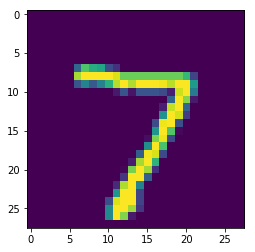

In [8]:
# 用 predict 在测试集上对模型进行推理
test_result = model.predict(test_dataset)
# 由于模型是单一输出，test_result的形状为[1, 10000]，10000是测试数据集的数据量。这里打印第一个数据的结果，这个数组表示每个数字的预测概率
print(len(test_result))
print(test_result[0][0])

# 从测试集中取出一张图片
img, label = test_dataset[0]

# 打印推理结果，这里的argmax函数用于取出预测值中概率最高的一个的下标，作为预测标签
pred_label = test_result[0][0].argmax()
print("true label: {}, pred label: {}".format(label[0], pred_label))
# 使用matplotlib库，可视化图片
from matplotlib import pyplot as plt

plt.imshow(img[0])


示例中对测试集 `test_dataset` 中每一个样本执行预测，测试数据集中包含 10000 个数据，因此将取得 10000 个预测输出。

打印第一个样本数据的预测输出，可以看到，在手写数字识别任务中，经过模型的计算得到一个数组 [[ -6.5593615  -6.4680595  -1.4708003   2.1043894 -11.743436   -4.4516582
  -14.733968   12.036645   -6.582403   -1.8672216]]，取其中最大的值（12.036645）的下标（对应 label 7），即得到该样本数据的预测结果（pred label: 7），可视化该样本图像（true label: 7），与预测结果一致，说明模型准确预测了样本图像上的数字。



除了上面介绍的三个 API 之外， `paddle.Model` 类也提供了其他与训练、评估与推理相关的 API：

* [Model.train_batch](../../api/paddle/Model_cn.html#train-batch-inputs-labels-none-update-true)：在一个批次的数据集上进行训练；
* [Model.eval_batch](../../api/paddle/Model_cn.html#eval-batch-inputs-labels-none)：在一个批次的数据集上进行评估；
* [Model.predict_batch](../../api/paddle/Model_cn.html#predict-batch-inputs)：在一个批次的数据集上进行推理。

这三个 API 与上面介绍的三个 API 的输入数据的维度有所不同，详细介绍可参考对应 API 文档。


## 三、使用基础 API 训练、评估与推理

除了通过高层 API 实现模型的训练、评估与推理，飞桨框架也同样支持通过基础 API。简单来说， `Model.prepare` 、 `Model.fit` 、 `Model.evaluate` 、 `Model.predict` 都是由基础 API 封装而来。下面通过拆解高层 API 到基础 API 的方式，来了解如何用基础 API 完成模型训练、评估与推理。


### 3.1 模型训练（拆解 Model.prepare、Model.fit）

飞桨框架通过基础 API 对模型进行训练，对应高层 API 的 `Model.prepare` 与 `Model.fit` ，一般包括如下几个步骤：

1. 加载训练数据集、声明模型、设置模型实例为 `train` 模式
1. 设置优化器、损失函数与各个超参数
1. 设置模型训练的二层循环嵌套，并在内层循环嵌套中设置如下内容
    - 3.1 从数据读取器 DataLoader 获取一批次训练数据
    - 3.2 执行一次预测，即经过模型计算获得输入数据的预测值
    - 3.3 计算预测值与数据集标签的损失
    - 3.4 计算预测值与数据集标签的准确率
    - 3.5 将损失进行反向传播
    - 3.6 打印模型的轮数、批次、损失值、准确率等信息
    - 3.7 执行一次优化器步骤，即按照选择的优化算法，根据当前批次数据的梯度更新传入优化器的参数
    - 3.8 将优化器的梯度进行清零
    


In [9]:
# dataset与mnist的定义与使用高层API的内容一致
# 用 DataLoader 实现数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 将mnist模型及其所有子层设置为训练模式。这只会影响某些模块，如Dropout和BatchNorm。
mnist.train()

# 设置迭代次数
epochs = 5

# 设置优化器
optim = paddle.optimizer.Adam(parameters=mnist.parameters())
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):
        x_data = data[0]  # 训练数据
        y_data = data[1]  # 训练数据标签
        predicts = mnist(x_data)  # 预测结果

        # 计算损失 等价于 prepare 中loss的设置
        loss = loss_fn(predicts, y_data)

        # 计算准确率 等价于 prepare 中metrics的设置
        acc = paddle.metric.accuracy(predicts, y_data)

        # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中
        # 反向传播
        loss.backward()

        if (batch_id + 1) % 900 == 0:
            print(
                "epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(
                    epoch, batch_id + 1, loss.numpy(), acc.numpy()
                )
            )
        # 更新参数
        optim.step()
        # 梯度清零
        optim.clear_grad()

epoch: 0, batch_id: 900, loss is: [0.06991791], acc is: [0.96875]
epoch: 1, batch_id: 900, loss is: [0.02878829], acc is: [1.]
epoch: 2, batch_id: 900, loss is: [0.07192856], acc is: [0.96875]
epoch: 3, batch_id: 900, loss is: [0.20411499], acc is: [0.96875]
epoch: 4, batch_id: 900, loss is: [0.13589518], acc is: [0.96875]


### 3.2 模型评估（拆解 Model.evaluate）

飞桨框架通过基础 API 对训练好的模型进行评估，对应高层 API 的 `Model.evaluate` 。与模型训练相比，模型评估的流程有如下几点不同之处：

1. 加载的数据从训练数据集改为测试数据集
1. 模型实例从 `train` 模式改为 `eval` 模式
1. 不需要反向传播、优化器参数更新和优化器梯度清零



In [10]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
# 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
mnist.eval()
# 禁用动态图梯度计算
for batch_id, data in enumerate(test_loader()):
    x_data = data[0]  # 测试数据
    y_data = data[1]  # 测试数据标签
    predicts = mnist(x_data)  # 预测结果

    # 计算损失与精度
    loss = loss_fn(predicts, y_data)
    acc = paddle.metric.accuracy(predicts, y_data)

    # 打印信息
    if (batch_id + 1) % 30 == 0:
        print(
            "batch_id: {}, loss is: {}, acc is: {}".format(
                batch_id + 1, loss.numpy(), acc.numpy()
            )
        )

batch_id: 30, loss is: [0.23106411], acc is: [0.953125]
batch_id: 60, loss is: [0.4329119], acc is: [0.90625]
batch_id: 90, loss is: [0.07333981], acc is: [0.96875]
batch_id: 120, loss is: [0.00324837], acc is: [1.]
batch_id: 150, loss is: [0.0857158], acc is: [0.96875]


### 3.3 模型推理（拆解 Model.predict）

飞桨框架通过基础 API 对训练好的模型执行推理，对应高层 API 的 `Model.predict` 。模型的推理过程相对独立，是在模型训练与评估之后单独进行的步骤。只需要执行如下步骤：

1. 加载待执行推理的测试数据，并将模型设置为 `eval` 模式
1. 读取测试数据并获得预测结果
1. 对预测结果进行后处理

predict finished
true label: 7, pred label: 7


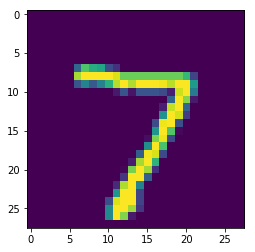

In [11]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 将该模型及其所有子层设置为预测模式
mnist.eval()
for batch_id, data in enumerate(test_loader()):
    # 取出测试数据
    x_data = data[0]
    # 获取预测结果
    predicts = mnist(x_data)
print("predict finished")

# 从测试集中取出一组数据
img, label = test_loader().next()

# 执行推理并打印结果
pred_label = mnist(img)[0].argmax()
print(
    "true label: {}, pred label: {}".format(
        label[0].item(), pred_label[0].item()
    )
)
# 可视化图片
from matplotlib import pyplot as plt

plt.imshow(img[0][0])

## 四、总结

本节中介绍了在飞桨框架中使用高层 API 进行模型训练、评估和推理的方法，并拆解出对应的基础 API 实现方法。需要注意的是，这里的推理仅用于模型效果验证，实际生产应用中，则可使用飞桨提供的一系列推理部署工具，满足服务器端、移动端、网页/小程序等多种环境的模型部署上线需求，具体可参见 [推理部署](../infer/index_cn.html) 章节。

同时，飞桨的高层 API 和基础 API 可以组合使用，并不是完全割裂开的，这样有助于开发者更便捷地完成算法迭代。示例代码如下：



In [10]:
from paddle.vision.models import LeNet


class FaceNet(paddle.nn.Layer):
    def __init__(self):
        super().__init__()
        # 使用高层API组网
        self.backbone = LeNet()
        # 使用基础API组网
        self.outLayer1 = paddle.nn.Sequential(
            paddle.nn.Linear(10, 512), paddle.nn.ReLU(), paddle.nn.Dropout(0.2)
        )
        self.outLayer2 = paddle.nn.Linear(512, 10)

    def forward(self, inputs):
        out = self.backbone(inputs)
        out = self.outLayer1(out)
        out = self.outLayer2(out)
        return out


# 使用高层API封装网络
model = paddle.Model(FaceNet())
# 使用基础API定义优化器
optim = paddle.optimizer.Adam(learning_rate=1e-3, parameters=model.parameters())
# 使用高层API封装优化器和损失函数
model.prepare(
    optim, paddle.nn.CrossEntropyLoss(), metrics=paddle.metric.Accuracy()
)
# 使用高层API训练网络
model.fit(train_dataset, test_dataset, epochs=5, batch_size=64, verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5
step 938/938 [==============================] - loss: 0.0863 - acc: 0.9369 - 22ms/step          
Eval begin...
step 157/157 [==============================] - loss: 0.1034 - acc: 0.9741 - 8ms/step          
Eval samples: 10000
Epoch 2/5
step 938/938 [==============================] - loss: 0.0366 - acc: 0.9769 - 21ms/step          
Eval begin...
step 157/157 [==============================] - loss: 0.0047 - acc: 0.9835 - 8ms/step          
Eval samples: 10000
Epoch 3/5
step 938/938 [==============================] - loss: 0.0073 - acc: 0.9813 - 21ms/step          
Eval begin...
step 157/157 [==============================] - loss: 0.0345 - acc: 0.9818 - 9ms/step          
Eval samples: 10000
Epoch 4/5
step 938/938 [==============================] - loss: 0.0025 - acc: 0.9842 - 21ms/step          
Eval begin...
step 157/157 [==============================] - loss: 0.00